# Lecture 28 : Sobel Edge Detector (solution)

In [1]:
import numpy as np # for matrix processing
from PIL import Image, ImageOps # for image processing

In [ ]:
# clone a public repo on Github to images
!git clone https://github.com/jasonrwilson/cmda.git

In [2]:
# copy the image files to our working directory
!cp cmda/*.jpg .

# Part 1 : Padding 2d Arrays in Python

In [4]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
(rows,cols) = A.shape
A_pad = np.pad(A,[1,1],'constant',constant_values = 0)
print (A_pad)

[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]


# Part 2 : Working with .jpg Images in Python

In [5]:
car = Image.open("car.jpg")
car

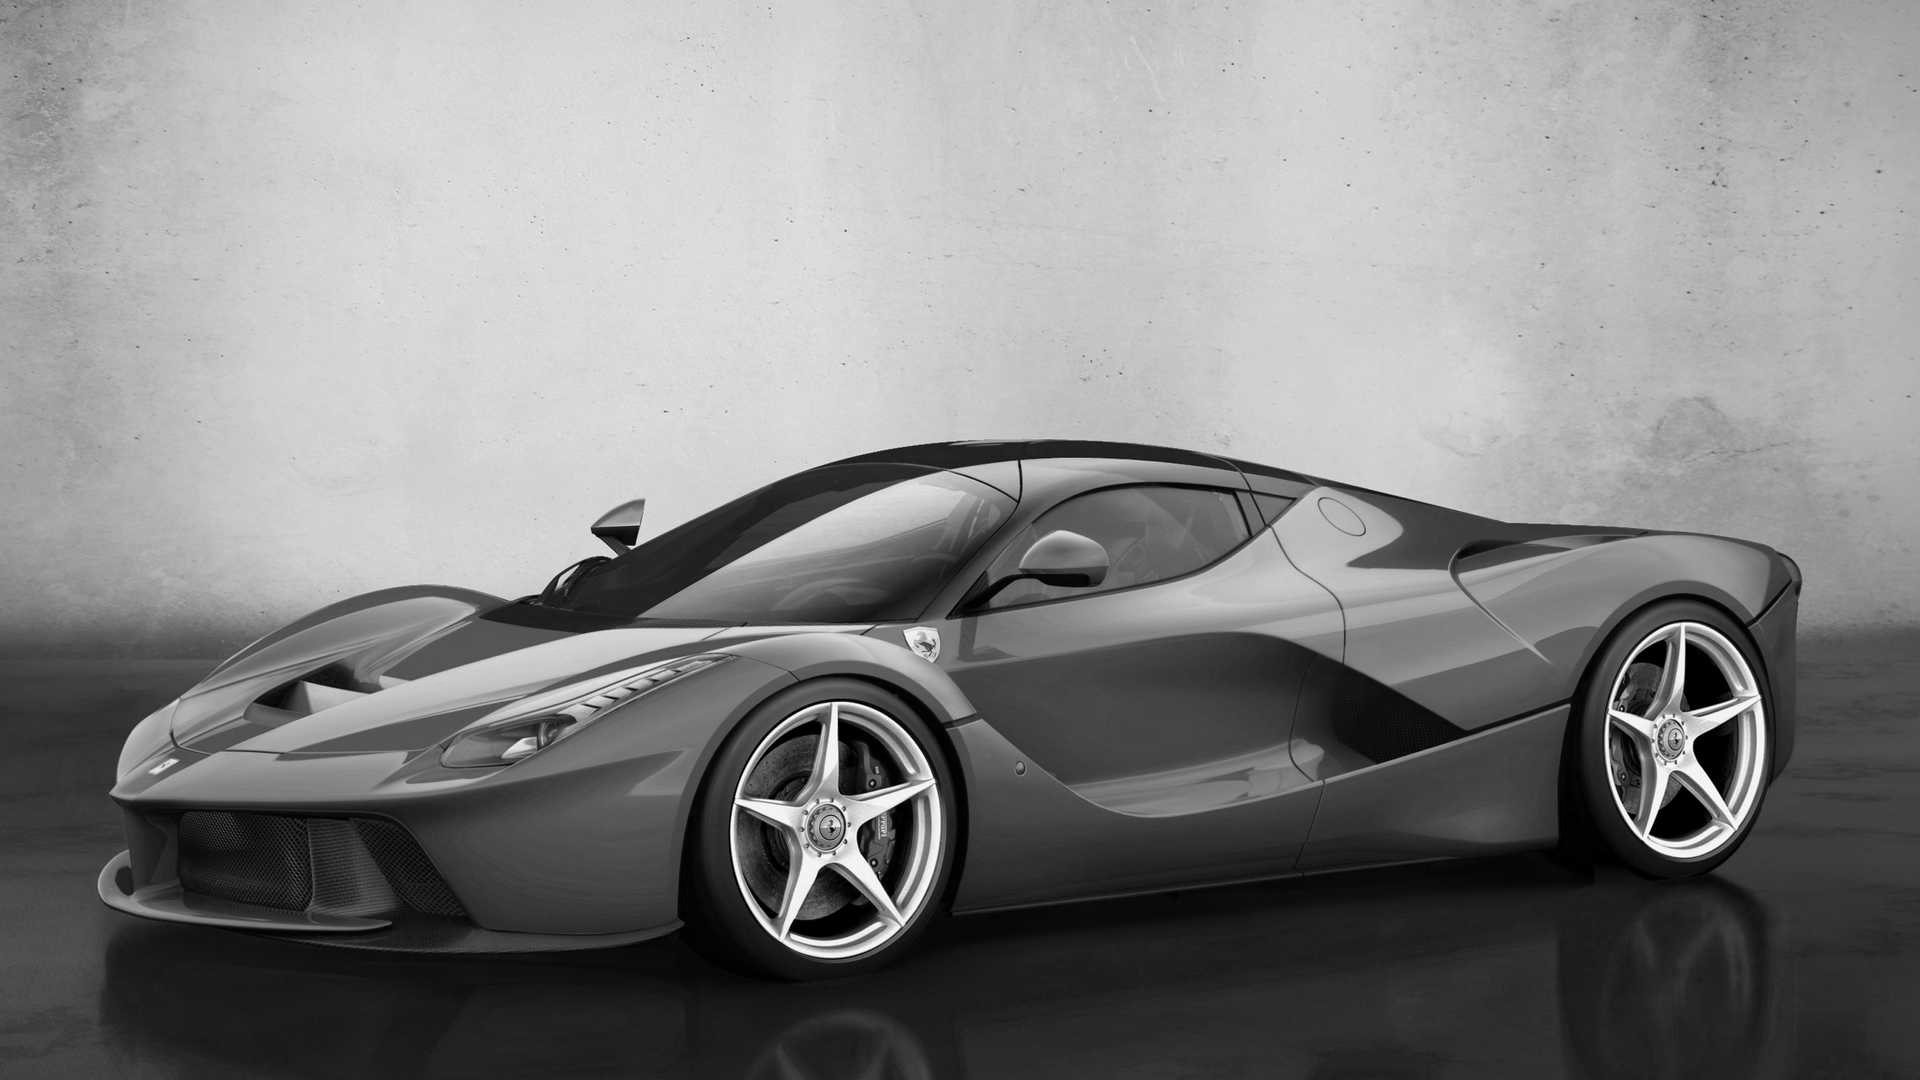

In [6]:
grayCar = ImageOps.grayscale(car)
grayCar

In [7]:
width,height = grayCar.size
print('grayscale bike image is ',height,' pixels tall and ',width,' pixels wide.')

grayscale bike image is  1080  pixels tall and  1920  pixels wide.


In [8]:
A = np.array(grayCar).astype(np.int32)

In [9]:
rows,cols = A.shape
print ('A has ',rows,'rows and ',cols,' columns.')

A has  1080 rows and  1920  columns.


# Part 3 : Sobel Edge Detection in Python

Sobel edge detection consists of the following two kernels that we apply to each pixel in the image to detect vertical and horizontal edges.

$$\begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix} \qquad
\begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

Example : Apply each kernel to the center pixel of the following image matrix.

$$\begin{bmatrix} 1 & 1 & 1 \\ 0 & 0 & 0 \\ 2 & 2 & 2 \end{bmatrix}$$

We apply the first kernel which detects vertical edges:

$$G_x = (-1)(1) + 0(1) + 1(1) + (-2)(0) + 0(0) + 2(0) + (-1)(2) + 0(2) + 1(2) = 0$$

We apply the second kernel which detects horizontal edges:

$$G_y = (1)(1) + 2(1) + 1(1) + 0(0) + 0(0) + 0(0) + (-1)(2) + (-2)(2) + (-1)(2) = -4$$

To combine the results of the detectors we use the formula
$$|G| = |G_x| + |G_y| = 0 + 4 = 4$$

Given a $3 \times 3$ piece of an image matrix
$$\begin{bmatrix} P_1 & P_2 & P_3 \\ P_4 & P_5 & P_6 \\ P_7 & P_8 & P_9 \end{bmatrix}$$

we can compute value of $|G|$ at the pixel $P_5$ using the formula
$$|G| = |P_3 + 2P_6 + P_9 - P_1 - 2P_4 - P_7| + |P_1+2P_2+P_3-P_7-2P_8-P_9|$$

We will pad the perimeter of the image matrix with zeros to ensure that the above formula can be computed at each pixel.

We can threshold the value of $|G|$ to determine whether to color the pixel black (when $|G| \leq$ threshold) or
white (when $|G| > $ threshold).   





CPU times: user 27.5 s, sys: 57.1 ms, total: 27.6 s
Wall time: 27.7 s


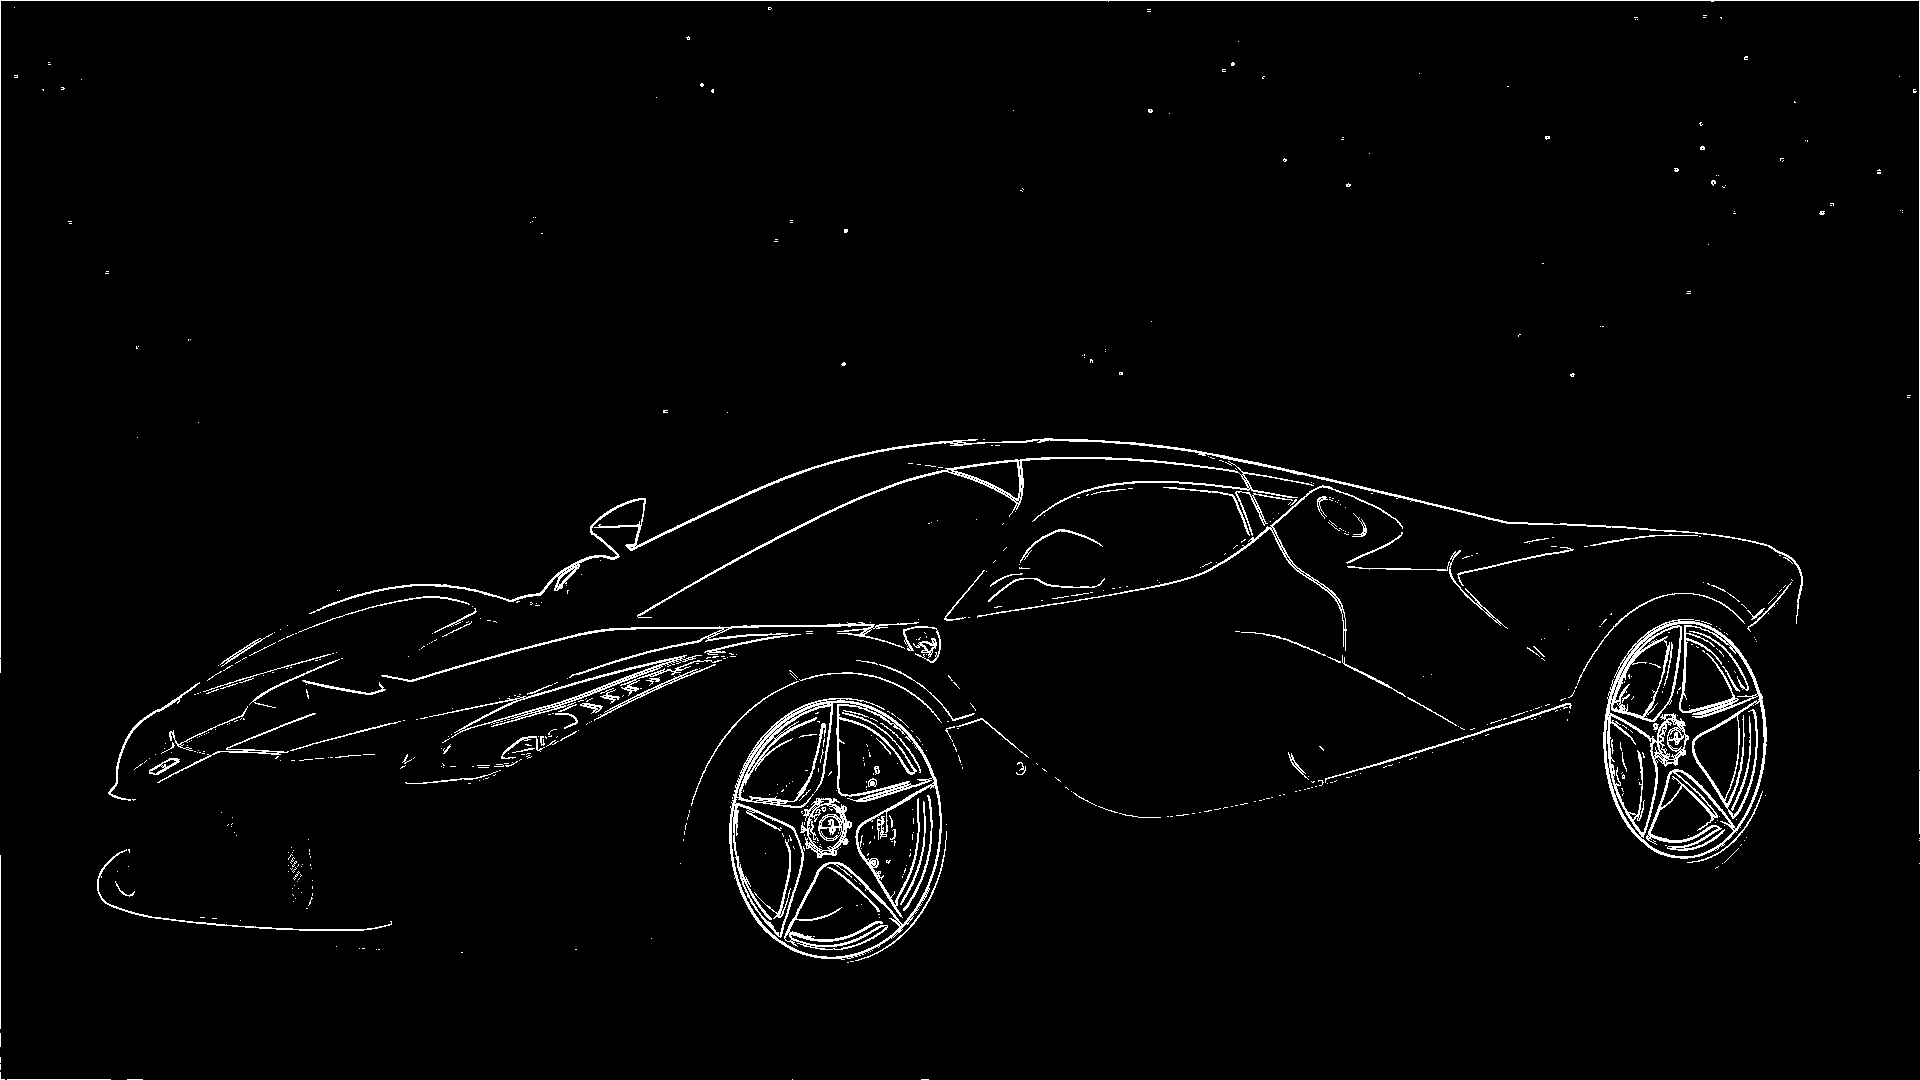

In [10]:
%%time
threshold = 250
A_pad = np.pad(A,[1,1],'constant',constant_values = 0)
E = np.zeros((rows,cols),dtype='uint8')
for i in range(1,rows+1):
    for j in range(1,cols+1):
        P1 = A_pad[i-1][j-1]
        P2 = A_pad[i-1][j]
        P3 = A_pad[i-1][j+1]
        P4 = A_pad[i][j-1]
        P6 = A_pad[i][j+1]
        P7 = A_pad[i+1][j-1]
        P8 = A_pad[i+1][j]
        P9 = A_pad[i+1][j+1]
        Gx = P3+2*P6+P9-P1-2*P4-P7
        Gy = P1+2*P2+P3-P7-2*P8-P9
        size = np.abs(Gx)+np.abs(Gy)
        if (size > threshold):
            E[i-1][j-1] = 255
edges = Image.fromarray(E)
edges

# Part 4 : Profiling the Python Code

Note: most of the runtime is spent in the nested for loop.

In [11]:
%%writefile sobel.py
import sys # for command line arguments
import numpy as np # for matrix processing
from PIL import Image, ImageOps # for image processing
import time # to time part of the code

# make sure command line arguments are provided
if (len(sys.argv) < 4):
    print ('command usage :',sys.argv[0],'infile','outfile','threshold')
    exit(1)
infile = sys.argv[1]
outfile = sys.argv[2]
threshold = int(sys.argv[3])

# open the input image, convert to grayscale,
# convert to a matrix, and determine the rows and cols
input = Image.open(infile)
gray = ImageOps.grayscale(input)
A = np.array(gray).astype(np.int32)
rows,cols = A.shape

# pad the perimeter of the image matrix with zeros
# and create the E matrix initialized to all zeros
A_pad = np.pad(A,[1,1],'constant',constant_values = 0)
E = np.zeros((rows,cols),dtype='uint8')

# time just the Sobel edge detector
start = time.process_time()

# Sobel Edge Detector
for i in range(1,rows+1):
    for j in range(1,cols+1):
        P1 = A_pad[i-1][j-1]
        P2 = A_pad[i-1][j]
        P3 = A_pad[i-1][j+1]
        P4 = A_pad[i][j-1]
        P6 = A_pad[i][j+1]
        P7 = A_pad[i+1][j-1]
        P8 = A_pad[i+1][j]
        P9 = A_pad[i+1][j+1]
        Gx = P3+2*P6+P9-P1-2*P4-P7
        Gy = P1+2*P2+P3-P7-2*P8-P9
        size = np.abs(Gx)+np.abs(Gy)
        if (size > threshold):
            E[i-1][j-1] = 255

# record and print elapsed time
elapsed = time.process_time()-start
print ('Time to Run Nested For Loop in Python =',np.round(elapsed,4),'seconds')

# create the edges image
edges = Image.fromarray(E)
edges.save(outfile)

Writing sobel.py


In [ ]:
!time python3 sobel.py car.jpg car_edges_python.jpg 250

Time to Run Nested For Loop in Python = 28.1894 seconds

real	0m28.598s
user	0m28.385s
sys	0m0.154s


# Part 5 : Writing the Nested For Loop in C

# Class exercise: Complete the C code below to implement the nested for loop.  

Hint: Translate the Python code in lines 31-45 above into C.  You will have to use the flat memory model in C.  

Be careful: the A_pad matrix has 2 extra rows and 2 extra columns due to the zero padding!

Note: Since we are not yet using a GPU you should use a standard CPU runtime for this exercise!

In [ ]:
%%writefile sobel.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

typedef unsigned char byte;

void sobel(byte* A_pad, byte* E, int rows, int cols, int threshold) {
    clock_t begin = clock();

    for (int i=1;i<=rows;i++) {
        for (int j=1;j<=cols;j++) {
            int P1 = A_pad[(i-1)*(cols+2)+j-1];
            int P2 = A_pad[(i-1)*(cols+2)+j];
            int P3 = A_pad[(i-1)*(cols+2)+j+1];
            int P4 = A_pad[i*(cols+2)+j-1];
            int P6 = A_pad[i*(cols+2)+j+1];
            int P7 = A_pad[(i+1)*(cols+2)+j-1];
            int P8 = A_pad[(i+1)*(cols+2)+j];
            int P9 = A_pad[(i+1)*(cols+2)+j+1];
            int Gx = P3+2*P6+P9-P1-2*P4-P7;
            int Gy = P1+2*P2+P3-P7-2*P8-P9;
            int size = abs(Gx)+abs(Gy);
            if (size > threshold) {
                E[(i-1)*cols+j-1] = 255;
            }
        }
    }

    clock_t end = clock();
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
    printf ("Time to Run Nested For Loop in C = %.6lf seconds\n",time_spent);
}

Compile your C code into a shared object library that can be called by Python.

In [6]:
!gcc -O3 -fPIC -shared -o sobel.so sobel.c

The Python code for Sobel edge detection that calls your C function for the nested for loop.

In [ ]:
%%writefile c_sobel.py
import sys # for command line arguments
import numpy as np # for matrix processing
from PIL import Image, ImageOps # for image processing
import ctypes as ct # for calling C from Python
lib = ct.cdll.LoadLibrary("./sobel.so") # load C sobel edge detector

# make sure command line arguments are provided
if (len(sys.argv) < 4):
    print ('command usage :',sys.argv[0],'infile','outfile','threshold')
    exit(1)
infile = sys.argv[1]
outfile = sys.argv[2]
threshold = int(sys.argv[3])

# open the input image, convert to grayscale,
# convert to a matrix, and determine the rows and cols
input = Image.open(infile)
gray = ImageOps.grayscale(input)
A = np.array(gray)
rows,cols = A.shape

# pad the perimeter of the image matrix with zeros
# and create the E matrix initialized to all zeros
A_pad = np.pad(A,[1,1],'constant',constant_values = 0)
E = np.zeros((rows,cols),dtype='uint8')

# call the C sobel edge detector
A_pad_cptr = A_pad.ctypes.data_as(ct.POINTER(ct.c_uint8))
E_cptr = E.ctypes.data_as(ct.POINTER(ct.c_uint8))
lib.sobel(A_pad_cptr,E_cptr,ct.c_int(rows),ct.c_int(cols),ct.c_int(threshold))

# create the edges image
edges = Image.fromarray(np.uint8(E))
edges.save(outfile)

Time the Python script that calls the C code for the computationally intensive task.  

In [ ]:
# clone a public repo on Github to images
!git clone https://github.com/jasonrwilson/cmda.git

In [9]:
# copy the image files to our working directory
!cp cmda/*.jpg .

In [ ]:
!time python3 c_sobel.py car.jpg car_edges_c.jpg 250

Test your C code to ensure it outputs the correct edges.  

In [11]:
!diff car_edges_c.jpg car_edges_key.jpg

# C Speedup

How many times faster does the nested for loop run in C versus Python.

$$\text{speedup} = \frac{\text{Time to Run Nested For Loop in Python}}{\text{Time to Run Nested For Loop in C}} = \frac{28.1894}{0.008662} \approx 3254$$


# Part 6 : Writing the Nested For Loop in CUDA

# Class exercise: Complete the CUDA kernel below to implement the nested for loop.

### Note: Each thread handles a single pixel.  

In [ ]:
%%writefile gpu_sobel.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned char byte;

__global__ void sobelKernel(byte* A_pad, byte* E, int rows, int cols, int threshold) {

    int thread_num = blockIdx.x*blockDim.x+threadIdx.x;
    int i = thread_num/cols + 1;
    int j = thread_num%cols + 1;
    if (i <= rows) {
        int P1 = A_pad[(i-1)*(cols+2)+j-1];
        int P2 = A_pad[(i-1)*(cols+2)+j];
        int P3 = A_pad[(i-1)*(cols+2)+j+1];
        int P4 = A_pad[i*(cols+2)+j-1];
        int P6 = A_pad[i*(cols+2)+j+1];
        int P7 = A_pad[(i+1)*(cols+2)+j-1];
        int P8 = A_pad[(i+1)*(cols+2)+j];
        int P9 = A_pad[(i+1)*(cols+2)+j+1];
        int Gx = P3+2*P6+P9-P1-2*P4-P7;
        int Gy = P1+2*P2+P3-P7-2*P8-P9;
        int size = abs(Gx)+abs(Gy);
        if (size > threshold) {
            E[(i-1)*cols+j-1] = 255;
        }
    }
}

extern "C" void sobel(byte* A_pad, byte* E, int rows, int cols, int threshold) {

    /* each thread processes one pixel */
    printf ("number of rows = %d\n",rows);
    printf ("number of cols = %d\n",cols);
    printf ("number of pixels = %d\n",rows*cols);
    int B = 128;
    printf ("number of threads per block = %d\n",B);
    int G = (rows*cols+B-1)/B;
    printf ("number of thread blocks = %d\n",G);
    printf ("number of threads = %d\n",G*B);

    /* A_pad and E on the device */
    byte* d_A_pad;
    byte* d_E;
    cudaMalloc (&d_A_pad,(rows+2)*(cols+2));
    cudaMalloc (&d_E,rows*cols);

    /* copy A_pad from the host to the device */
    cudaMemcpy (d_A_pad, A_pad, (rows+2)*(cols+2), cudaMemcpyHostToDevice);

    /* for timing kernel execution */
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    /* launch the Sobel kernel */
    cudaEventRecord(start);
    sobelKernel <<< G, B >>> (d_A_pad,d_E,rows,cols,threshold);
    cudaEventRecord(stop);

    /* copy E from the device to host */
    cudaMemcpy (E, d_E, rows*cols, cudaMemcpyDeviceToHost);

    /* print kernel elapsed time */
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf ("Time to Run Nested For Loop on GPU = %.6lf seconds\n",milliseconds/1000);

}

Compile your CUDA code into a shared object library that can be called by Python.

In [2]:
!nvcc -Xcompiler -fPIC -shared -arch=sm_75 -O3 -o gpu_sobel.so gpu_sobel.cu

The Python code for Sobel edge detection that calls your CUDA function for the nested for loop.

In [ ]:
%%writefile gpu_sobel.py
import sys # for command line arguments
import numpy as np # for matrix processing
from PIL import Image, ImageOps # for image processing
import ctypes as ct # for calling C from Python
lib = ct.cdll.LoadLibrary("./gpu_sobel.so") # load GPU sobel edge detector

# make sure command line arguments are provided
if (len(sys.argv) < 4):
    print ('command usage :',sys.argv[0],'infile','outfile','threshold')
    exit(1)
infile = sys.argv[1]
outfile = sys.argv[2]
threshold = int(sys.argv[3])

# open the input image, convert to grayscale,
# convert to a matrix, and determine the rows and cols
input = Image.open(infile)
gray = ImageOps.grayscale(input)
A = np.array(gray)
rows,cols = A.shape

# pad the perimeter of the image matrix with zeros
# and create the E matrix initialized to all zeros
A_pad = np.pad(A,[1,1],'constant',constant_values = 0)
E = np.zeros((rows,cols),dtype='uint8')

# call the C sobel edge detector
A_pad_cptr = A_pad.ctypes.data_as(ct.POINTER(ct.c_uint8))
E_cptr = E.ctypes.data_as(ct.POINTER(ct.c_uint8))
lib.sobel(A_pad_cptr,E_cptr,ct.c_int(rows),ct.c_int(cols),ct.c_int(threshold))

# create the edges image
edges = Image.fromarray(E)
edges.save(outfile)

In [ ]:
# clone a public repo on Github to images
!git clone https://github.com/jasonrwilson/cmda.git

In [5]:
# copy the image files to our working directory
!cp cmda/*.jpg .

In [ ]:
!python3 gpu_sobel.py car.jpg car_edges_gpu.jpg 250

Test your CUDA code to ensure it outputs the correct edges.

In [7]:
!diff car_edges_gpu.jpg car_edges_key.jpg

### Time to run the nested for loop on the GPU is around 0.000082 seconds!

### In fact, modern GPUs are fast enough to process hundreds of images (e.g. video) in real time!